In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import librosa
from scipy.stats import kurtosis
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

In [ ]:
# to get relevant features 
def extract_features(y,sr=22050,n_fft=1024,hop_length=512):
    features = {'centroid': librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
                'chroma_stft': librosa.feature.chroma_stft(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
                'flux': librosa.onset.onset_strength(y=y, sr=sr).ravel(),
                'rmse': librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel(),
                'zcr': librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel(),
                'contrast': librosa.feature.spectral_contrast(y, sr=sr).ravel(),
                'bandwidth': librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
                'flatness': librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel(),
                'rolloff': librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()}

    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft=n_fft, hop_length=hop_length, n_mfcc=20)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx+1)] = v_mfcc.ravel()

    # Get statistics from the vectors
    def get_feature_stats(features):
        result = {}
        for k, v in features.items():
           # result['{}_max'.format(k)] = np.max(v)
            #result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            # result['{}_kurtosis'.format(k)] = kurtosis(v)
            # result['{}_skew'.format(k)] = skew(v)
        return result

    dict_agg_features = get_feature_stats(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y=y,sr=sr,hop_length=hop_length)[0]

    return dict_agg_features

In [ ]:
def make_train_data():
    arr_features=[]
    os.chdir('/home/ashita/ML-Project2021/datasets/GTZAN')
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    for idx,genre in tqdm(enumerate(genres),total=len(genres)):
        for fname in os.listdir(genre):
            try:
                y, sr = librosa.load(genre+'/'+fname, duration=3)
                dict_features=extract_features(y=y,sr=sr)
                dict_features['label']=idx
                arr_features.append(dict_features)
            except:
                pass

    df=pd.DataFrame(data=arr_features)
    print(df.head())
    print(df.shape)
    os.chdir('..')
    # os.chdir('..')
    df.to_csv('train_data2.csv',index=False)

In [ ]:
def make_test_data():
    arr_features=[]
    os.chdir('/home/ashita/ML-Project2021/datasets/GTZAN')
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    for fname in tqdm(os.listdir('test'),total=10*len(genres)):
            y, sr = librosa.load('test/'+fname, duration=30)
            dict_features=extract_features(y=y,sr=sr)
            dict_features['label']=genres.index(fname.split('.')[0])
            arr_features.append(dict_features)

    df=pd.DataFrame(data=arr_features)
    print(df.head())
    print(df.shape)
    os.chdir('..')
    df.to_csv('test_data.csv',index=False)

In [ ]:
df1=pd.read_csv('/home/ashita/ML-Project2021/datasets/train_data2.csv')
df=pd.read_csv('/home/ashita/ML-Project2021/datasets/GTZAN/features_3_sec.csv')
df3=pd.read_csv('/home/ashita/ML-Project2021/datasets/GTZAN/features_30_sec.csv')
df2=pd.read_csv('/home/ashita/ML-Project2021/train_data.csv')

In [ ]:
print("Columns with NA values are",list(df.columns[df.isnull().any()]))
df.columns
df.info()

In [ ]:
ax=sns.countplot(data=df,x='label',palette='deep')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
#to check mean and deviations
df.describe()

# Box plots of all features for each genre:

In [ ]:
#df=df.drop(columns=['filename','length','label'])
for col in list(df):
    try:
        x = df[["label", col]]
        fig, ax = plt.subplots(figsize=(16, 8));
        sns.boxplot(x = "label", y = col, data = x, palette = 'husl');
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 10);
        plt.xlabel("Genre", fontsize = 15)
        plt.ylabel(col, fontsize = 15)
        # plt.savefig("/home/ashita/ML-Project2021/datasets/saved/all_features/3/"+col+"3")
    except:
        pass

## NORMALISATION

## Correlation Matrix of MEAN Variables


In [ ]:
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="YlGnBu", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
# plt.savefig("/home/ashita/ML-Project2021/datasets/saved/Corr_Heatmap30_better.png")

## PCA

In [ ]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']
cols = X.columns
# normalize or Standarise
min_max_scaler = skp.StandardScaler()
# min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)
print(finalDf.groupby('label').count())
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label",palette="deep" ,alpha=0.7,s = 100)
plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
#plt.savefig("/home/ashita/ML-Project2021/datasets/saved/PCA_Scattert.png")

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

In [ ]:
sns.boxplot(x='pc1',y='label',data=finalDf,palette = 'husl')
plt.figure(figsize=(16,8))

In [ ]:
sns.boxplot(x='pc2',y='label',data=finalDf,palette = 'husl')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

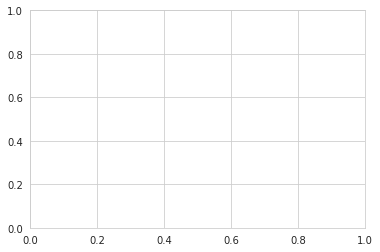

In [32]:
temp=X+1
am=np.mean(temp,axis=0)
gm=np.power(np.prod(temp,axis=0),1/temp.shape[0])
disp_ratio=am/gm
plt.bar(np.arange(X.shape[0]),disp_ratio,color='teal')